In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

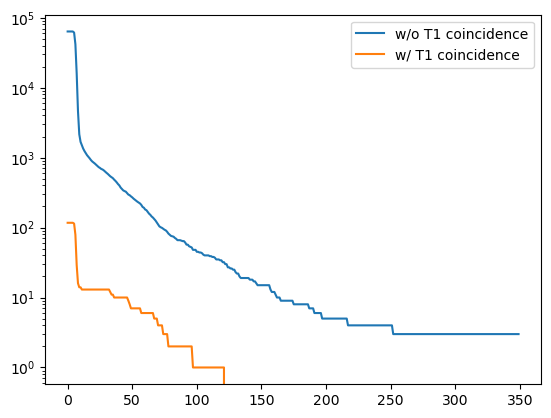

In [6]:
all_rates_t1 = np.zeros(350)
all_rates = np.zeros(350)

for file in os.listdir("/cr/tempdata01/filip/SSDCalib/Rates/with_T1"):
    try:
        all_rates_t1 += np.loadtxt("/cr/tempdata01/filip/SSDCalib/Rates/with_T1/" + file)
    except FileNotFoundError: pass

for file in os.listdir("/cr/tempdata01/filip/SSDCalib/Rates/without_T1"):
    try:
        all_rates += np.loadtxt("/cr/tempdata01/filip/SSDCalib/Rates/without_T1/" + file)
    except FileNotFoundError: pass

# def background(x):
#     return A * np.exp(-mu * (x-x_min))
# 
# all_rates = all_rates / (5000 * 800) 
# x_min, x_max = np.argmin(np.diff(all_rates)) + 5, 100
# A = all_rates[x_min]
# mu = -np.log(all_rates[x_max] / A) / (x_max - x_min)
# residuals = all_rates[x_min:x_max] - background(np.arange(x_min,x_max,1))

plt.plot(range(350), all_rates, label = "w/o T1 coincidence")
plt.plot(range(350), all_rates_t1, label = "w/ T1 coincidence")
plt.yscale("log")
plt.legend()